In [1]:
import tensorflow as tf

import chipscvn.utils as utils
import chipscvn.config as config
import chipscvn.data as data
import chipscvn.models as models
import chipscvn.evaluators as evaluators
utils.gpu_setup()  # Setup the GPU's

---  3 Physical GPUs, 3 Logical GPUs ---


In [2]:
conf = config.process_config("config/classification.yml")
evaluator = utils.get_evaluator(conf)
evaluator.run()

--- Running Evaluation ---

--- 59.7725625038147 seconds to test model ---


In [9]:
evaluator.inputs.head()

,raw_num_hits,filtered_num_hits,num_hough_rings,raw_total_digi_q,filtered_total_digi_q,first_ring_height,last_ring_height,reco_vtxX,reco_vtxY,reco_vtxZ,reco_dirTheta,reco_dirPhi,z_cut,r_cut,dir_cut,q_cut
0,179,154,2,906.677673,875.707642,714.646729,405.721893,690.166931,-755.358215,411.529846,0.640625,-19.687500,True,True,False,True
1,175,81,2,577.187317,431.922424,539.877930,431.726898,-560.377869,-884.082825,404.020416,-0.984375,-53.437504,True,True,False,True
2,409,341,4,1259.605835,1175.345459,859.090088,591.985046,864.878418,712.731934,-48.141529,-0.453125,-59.062496,True,True,False,True
3,480,407,2,1639.234985,1561.895508,1816.298340,1433.887329,-189.518356,1116.628052,-472.778442,0.484375,-14.062500,True,True,False,True
4,1471,1398,1,3490.017334,3399.132080,4127.127930,4127.127930,-362.062836,495.200287,21.175497,-0.109375,2.812500,True,True,True,True


In [10]:
evaluator.labels.head()

,true_pdg,true_type,true_category,true_vtxX,true_vtxY,true_vtxZ,true_dirTheta,true_dirPhi,true_nuEnergy,true_lepEnergy
0,1,1,3,675.334045,-780.369629,442.496979,-0.134944,6.458288,5794.160156,4610.879883
1,1,5,9,-532.549988,-660.750977,700.000000,-0.788648,-101.686317,2393.659912,2393.659912
2,1,5,9,1107.650024,1097.849976,700.000000,-0.860321,-116.572388,7798.709961,7798.709961
3,1,2,5,-318.386230,1064.633301,-442.021393,-0.114141,7.964214,7112.759766,4215.709961
4,0,0,0,-490.636536,450.946136,53.617542,-0.176611,10.312037,4031.449951,3628.760010


In [11]:
evaluator.predictions.head()

,true_category
0,"[0.00033048083, 0.1861814, 0.00014177388, 0.23..."
1,"[0.009988095, 0.00067220256, 0.041282445, 0.00..."
2,"[0.08327374, 0.016485143, 0.12272812, 0.039307..."
3,"[0.0051931073, 0.0091683315, 0.02206914, 0.065..."
4,"[0.52264386, 2.1102123e-07, 0.25801143, 1.1777..."


<Figure size 1152x720 with 0 Axes>

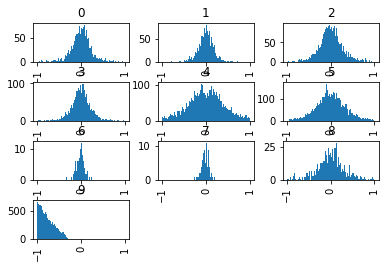

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
evaluator.labels.hist(column='true_dirTheta', by='true_category', bins=100, range=[-1,1])
plt.show()

In [29]:
import numpy as np

def prediction_classifier(row):
    combined_values = [
        row["true_category"][0]+row["true_category"][2]+row["true_category"][4]+row["true_category"][6],
        row["true_category"][1]+row["true_category"][3]+row["true_category"][5]+row["true_category"][7],
        row["true_category"][8],
        row["true_category"][9]
    ]
    return np.asarray(combined_values).argmax()
        
def label_classifier(row):
    if row["true_category"] in [0,2,4,6]:
        return 0
    elif row["true_category"] in [1,3,5,7]:
        return 1
    elif row["true_category"] == 8:
        return 2
    elif row["true_category"] == 9:
        return 3

evaluator.labels['category_combined'] = evaluator.labels.apply(label_classifier, axis=1)
evaluator.predictions['category_combined'] = evaluator.predictions.apply(prediction_classifier, axis=1)

evaluator.labels["category_combined"] = evaluator.labels["category_combined"].astype('int')
evaluator.predictions["category_combined"] = evaluator.predictions["category_combined"].astype('int')

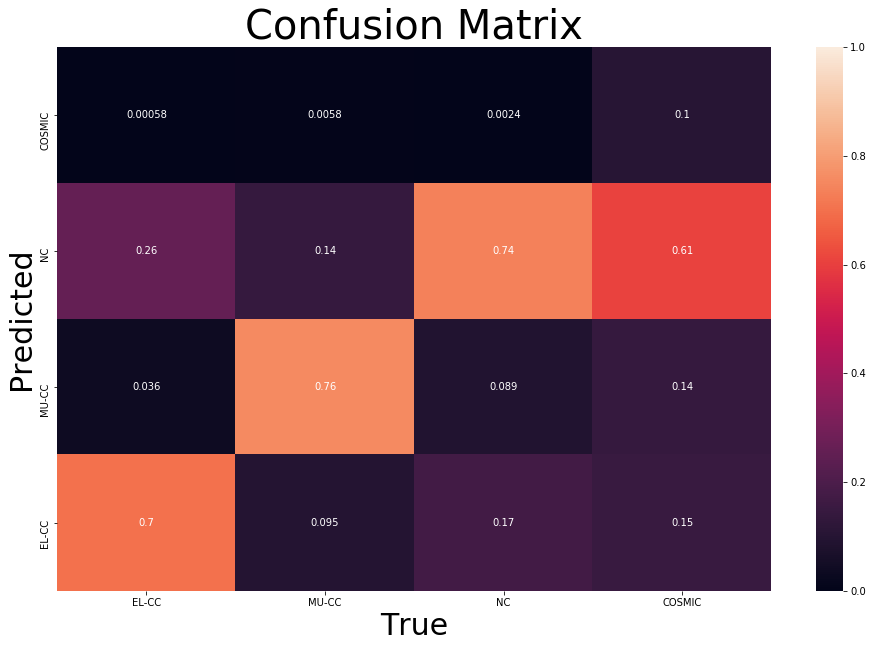

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
matrix = confusion_matrix(evaluator.labels["category_combined"], evaluator.predictions["category_combined"], normalize='true')
matrix_transpose = np.rot90(matrix, 1)
df_cm = pd.DataFrame(matrix_transpose, 
                     index = ["COSMIC", "NC", "MU-CC", "EL-CC"],
                     columns = ["EL-CC", "MU-CC", "NC", "COSMIC"])
plt.figure(figsize=(16,10))
sn.heatmap(df_cm, annot=True, vmin=0.0, vmax=1.0)
plt.title('Confusion Matrix', fontsize = 40) # title with fontsize 20
plt.xlabel('True', fontsize = 30) # x-axis label with fontsize 15
plt.ylabel('Predicted', fontsize = 30) # y-axis label with fontsize 15
plt.show()

In [32]:
from sklearn.metrics import classification_report
axis_labels = ["EL-CC", "MU-CC", "NC", "COSMIC"]
print(classification_report(evaluator.labels["category_combined"], evaluator.predictions["category_combined"], target_names=axis_labels))

              precision    recall  f1-score   support

       EL-CC       0.66      0.70      0.68      8668
       MU-CC       0.75      0.76      0.75      8565
          NC       0.23      0.74      0.35      4099
      COSMIC       0.94      0.10      0.18     10668

    accuracy                           0.52     32000
   macro avg       0.65      0.57      0.49     32000
weighted avg       0.72      0.52      0.49     32000



In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(evaluator.dense)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.1351797  0.05359691 0.04357604]


In [35]:
# Add in the labels
pca_df = pd.DataFrame(pca_result)
pca_df['category_combined'] = evaluator.labels['category_combined']
pca_df.rename(columns={0: "PCA1", 1: "PCA2", 2: "PCA3"}, inplace=True)
pca_df.head()

,PCA1,PCA2,PCA3,category_combined
0,-0.981659,-6.448878,-1.165533,1
1,-0.783133,3.919125,-3.205142,3
2,-1.165479,1.042875,-1.416070,3
3,-1.267317,-2.898458,2.161390,1
4,-0.975379,2.029077,7.957316,0


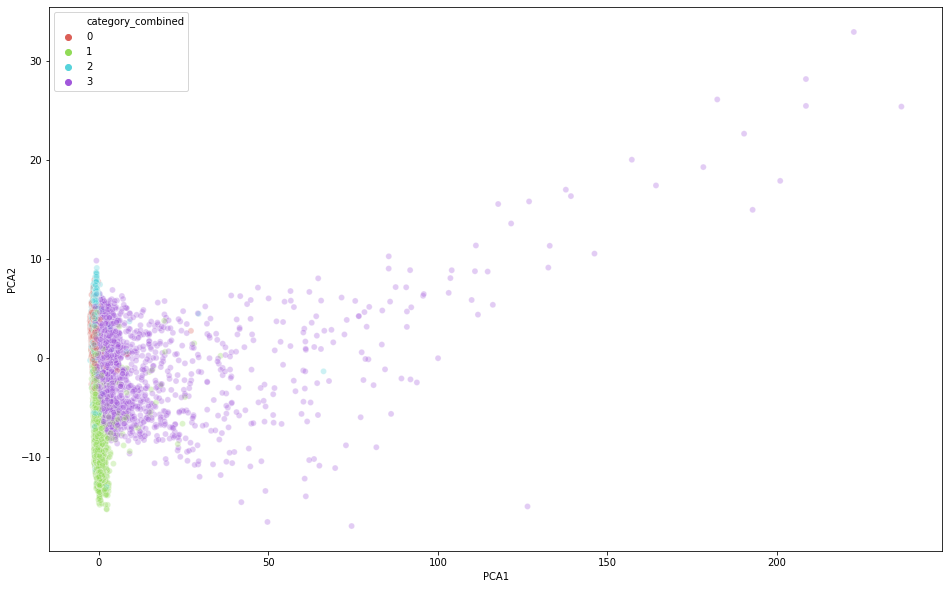

In [36]:
import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="PCA1", y="PCA2",
    hue="category_combined",
    palette=sns.color_palette("hls", 4),
    data=pca_df,
    legend="full",
    alpha=0.3
)
plt.show()

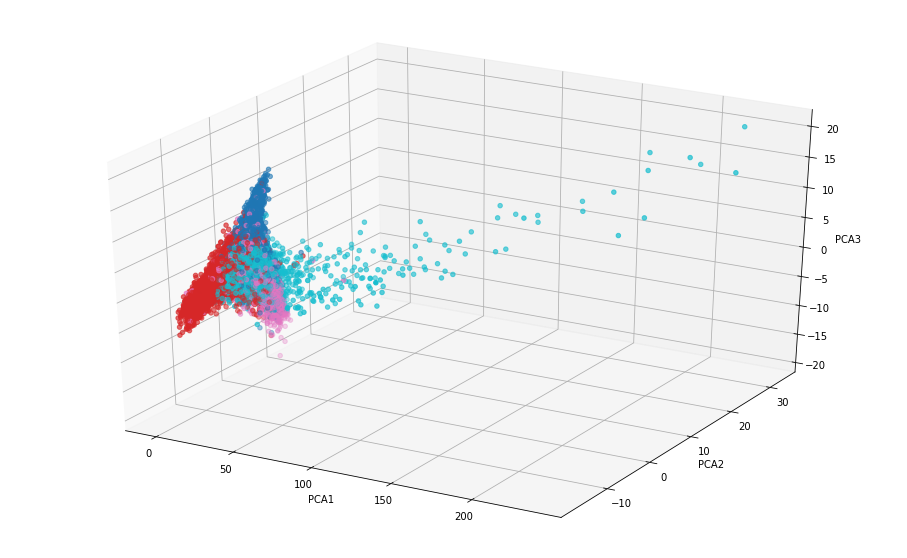

In [37]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_df["PCA1"], 
    ys=pca_df["PCA2"], 
    zs=pca_df["PCA3"], 
    c=pca_df["category_combined"], 
    cmap='tab10'
)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.show()

In [40]:
N = 20000
dense_subset = evaluator.dense[:N]
labels_subset = evaluator.labels[:N]

In [41]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 3.770s...
[t-SNE] Computed neighbors for 20000 samples in 524.164s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for 

In [42]:
tsne_df = pd.DataFrame(tsne_results)
tsne_df['category_combined'] = labels_subset['category_combined']
tsne_df.rename(columns={0: "tsne-2d-one", 1: "tsne-2d-two"}, inplace=True)
tsne_df.head()

,tsne-2d-one,tsne-2d-two,category_combined
0,-6.055521,4.162896,1
1,5.945337,-2.146487,3
2,2.331732,-0.628646,3
3,-1.850966,2.301320,1
4,-2.596765,-6.519473,0


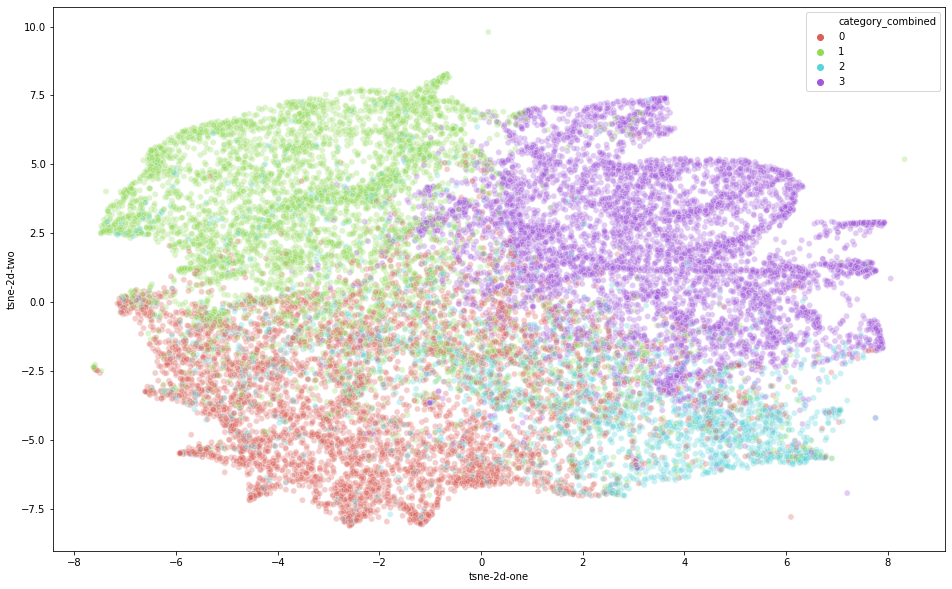

In [43]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="category_combined",
    palette=sns.color_palette("hls", 4),
    data=tsne_df,
    legend="full",
    alpha=0.3
)

In [45]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(evaluator.dense)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))
pca_50_df = pd.DataFrame(pca_result_50)
pca_50_df.head()

Cumulative explained variation for 50 principal components: 0.6400564908981323


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.981571,-6.448860,-1.165511,-4.424489,1.840809,2.002415,0.106339,3.459455,-3.757694,0.741180,...,-0.225567,-0.257455,0.193041,0.304843,-0.162099,0.386458,0.126524,-0.488412,-0.224487,0.258138
1,-0.783130,3.919097,-3.205143,0.319534,0.420217,-0.169316,0.513648,0.300556,-0.436473,0.426403,...,0.335515,-0.489258,0.173616,1.060439,0.118085,-1.763430,1.359936,0.982567,-0.926188,-0.008418
2,-1.165478,1.042845,-1.416061,0.488574,-1.910436,0.505025,1.379997,-0.232303,-0.133968,0.545027,...,0.498098,-0.049733,0.094385,0.179318,0.085996,0.081383,-0.336634,0.231154,0.253340,0.162875
3,-1.267320,-2.898449,2.161402,-1.108112,3.166925,-2.488685,0.253447,-0.417416,0.633455,0.448396,...,-0.679048,-0.323480,-0.349139,0.320932,0.174206,1.020545,-0.790320,-0.491735,-0.469659,-0.219394
4,-0.975378,2.029048,7.957340,-0.263167,-3.417638,3.613937,0.047137,0.745743,-0.913941,-0.105750,...,-0.463977,-0.110956,0.168351,-0.115100,0.257421,0.014522,-0.238977,0.229898,-0.222499,-0.104899


In [46]:
N = 20000
pca_50_subset = pca_50_df[:N]
labels_50_subset = evaluator.labels[:N]

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=1000, learning_rate=1000.0, early_exaggeration=12.0)
tsne_results_50 = tsne.fit_transform(pca_50_subset)

tsne_50_df = pd.DataFrame(tsne_results_50)
tsne_50_df['category_combined'] = labels_50_subset['category_combined']
tsne_50_df.rename(columns={0: "tsne-2d-one", 1: "tsne-2d-two"}, inplace=True)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="category_combined",
    palette=sns.color_palette("hls", 4),
    data=tsne_50_df,
    legend="full",
    alpha=0.3
)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.138s...
